<a href="https://colab.research.google.com/github/heekeermah/DSN-hackaton/blob/main/DSN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv
Saving SampleSubmission.csv to SampleSubmission.csv
Saving test.csv to test (1).csv


# IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

#LOADING THE DATA

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("SampleSubmission.csv")

# DATA PREPARATION

In [ ]:
# Previewing the training data
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Train preview:")
print(train.head())


Train shape: (4990, 13)
Test shape: (3532, 12)
Train preview:
  Item_ID      Store_ID       Item_Store_ID  Item_Weight Item_Sugar_Content  \
0   DRA12  BABATUNJI010  DRA12_BABATUNJI010         11.6          Low Sugar   
1   DRA12  BABATUNJI013  DRA12_BABATUNJI013         11.6          Low Sugar   
2   DRA12  BABATUNJI017  DRA12_BABATUNJI017         11.6          Low Sugar   
3   DRA12  BABATUNJI018  DRA12_BABATUNJI018         11.6          Low Sugar   
4   DRA12  BABATUNJI035  DRA12_BABATUNJI035         11.6    Ultra Low Sugar   

   Item_Visibility    Item_Type  Item_Price  Store_Start_Year Store_Size  \
0         0.068535  Soft Drinks      357.54              2005        NaN   
1         0.040912  Soft Drinks      355.79              1994       High   
2         0.041178  Soft Drinks      350.79              2014        NaN   
3         0.041113  Soft Drinks      355.04              2016     Medium   
4         0.000000  Soft Drinks      354.79              2011      Small   

  Stor

In [ ]:
# DATA MERGING FOR UNIFIED PROCESSING
# =====================================
train['source'] = 'train'
test['source'] = 'test'
test['Item_Store_Returns'] = np.nan  # temporarily add target for preprocessing

data = pd.concat([train, test], ignore_index=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Item_ID              8522 non-null   object 
 1   Store_ID             8522 non-null   object 
 2   Item_Weight          8522 non-null   float64
 3   Item_Sugar_Content   8522 non-null   int64  
 4   Item_Visibility      8522 non-null   float64
 5   Item_Type            8522 non-null   int64  
 6   Item_Price           8522 non-null   float64
 7   Store_Size           8522 non-null   int64  
 8   Store_Location_Type  8522 non-null   int64  
 9   Store_Type           8522 non-null   int64  
 10  Item_Store_Returns   8522 non-null   float64
 11  source               8522 non-null   object 
 12  Store_Age            8522 non-null   int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 865.6+ KB


feature enginering

In [ ]:
# Price per weight
data['Price_per_Weight'] = data['Item_Price'] / (data['Item_Weight'] + 1e-5)

# Visibility Score (normalize per store)
data['Visibility_Score'] = data.groupby('Store_ID')['Item_Visibility'].transform(lambda x: x / x.max())

# Price buckets (categorical)
data['Price_Bucket'] = pd.cut(data['Item_Price'], bins=[0, 100, 200, 300, 400, 500, np.inf],
                               labels=['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extreme'])


In [ ]:
# Drop columns not needed
data.drop(['source', 'Item_ID','Store_ID'], axis=1, inplace=True)

In [ ]:
# Encode categorical features
categorical_cols = ['Item_Sugar_Content', 'Item_Type', 'Store_Size', 'Store_Location_Type', 'Store_Type', 'Price_Bucket']
le = LabelEncoder()

for col in categorical_cols:
    data[col] = le.fit_transform(data[col].astype(str))


handling missing error

In [ ]:
data.fillna(data.mean(numeric_only=True), inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Item_ID              8522 non-null   object 
 1   Store_ID             8522 non-null   object 
 2   Item_Weight          8522 non-null   float64
 3   Item_Sugar_Content   8522 non-null   int64  
 4   Item_Visibility      8522 non-null   float64
 5   Item_Type            8522 non-null   int64  
 6   Item_Price           8522 non-null   float64
 7   Store_Size           8522 non-null   int64  
 8   Store_Location_Type  8522 non-null   int64  
 9   Store_Type           8522 non-null   int64  
 10  Item_Store_Returns   8522 non-null   float64
 11  source               8522 non-null   object 
 12  Store_Age            8522 non-null   int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 865.6+ KB


# EDA

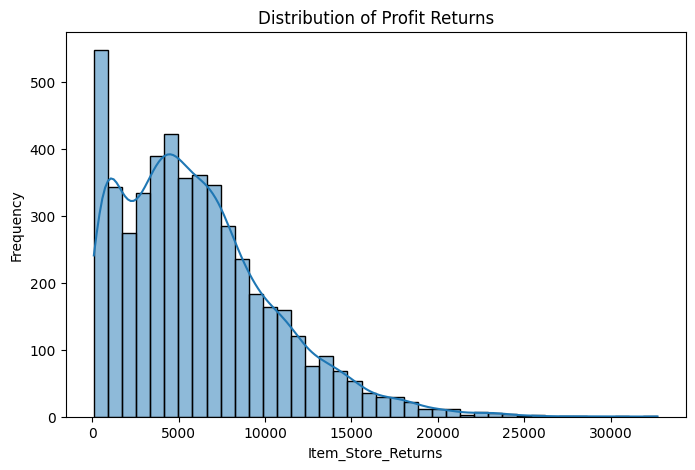

In [ ]:
# --- Distribution of Target Variable ---
plt.figure(figsize=(8,5))
sns.histplot(train['Item_Store_Returns'], bins=40, kde=True)
plt.title('Distribution of Profit Returns')
plt.xlabel('Item_Store_Returns')
plt.ylabel('Frequency')
plt.show()

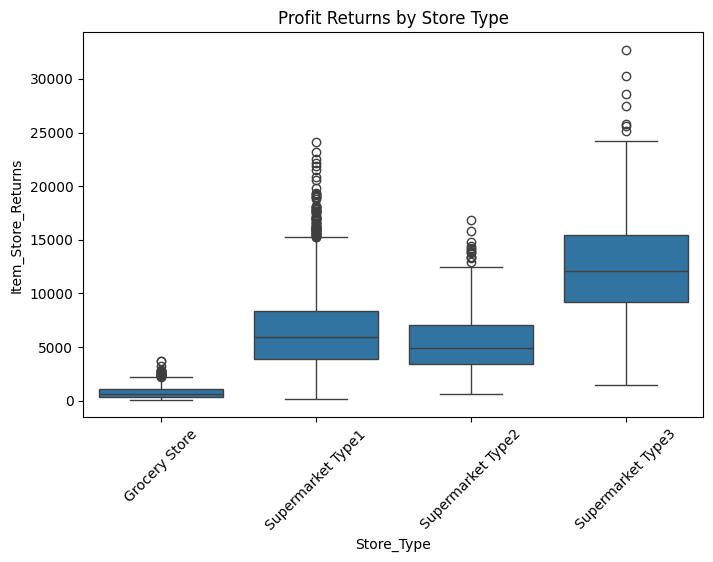

In [ ]:
# --- Boxplot: Profit Returns by Store Type ---
plt.figure(figsize=(8,5))
sns.boxplot(x='Store_Type', y='Item_Store_Returns', data=train)
plt.title('Profit Returns by Store Type')
plt.xticks(rotation=45)
plt.show()

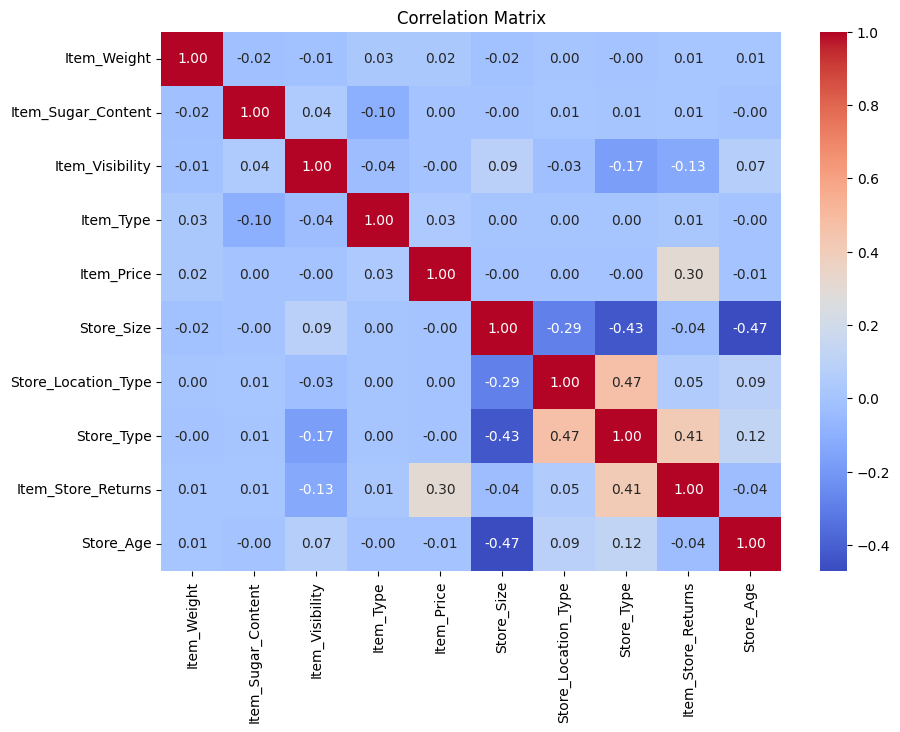

In [ ]:
# --- Correlation Heatmap ---
plt.figure(figsize=(10,7))
# Dropping non-numeric columns before calculating correlation
numeric_data = data.drop(['Item_ID', 'Store_ID', 'source'], axis=1)
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

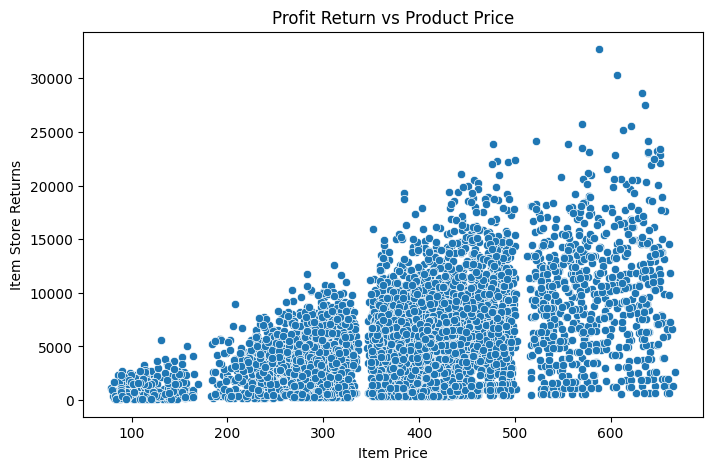

In [ ]:
# --- Profit vs Price ---
plt.figure(figsize=(8,5))
sns.scatterplot(x='Item_Price', y='Item_Store_Returns', data=train)
plt.title('Profit Return vs Product Price')
plt.xlabel('Item Price')
plt.ylabel('Item Store Returns')
plt.show()


# SPLITTING INTO TRAIN AND TEST DATA

In [ ]:
train_data = data[data['source'] == 'train'].drop('source', axis=1)
test_data = data[data['source'] == 'test'].drop(['source', 'Item_Store_Returns'], axis=1)

X_train = train_data.drop(['Item_Store_Returns', 'Item_ID', 'Store_ID'], axis=1)
y_train = train_data['Item_Store_Returns']

# MODEL TRAINING

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

#MODEL EVALUATION

In [ ]:
# Splitting the train data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_tr, y_tr)
y_pred_val = model.predict(X_val)

print("MAE:", mean_absolute_error(y_val, y_pred_val))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_val)))
print("R² Score:", r2_score(y_val, y_pred_val))

MAE: 2253.7487430861725
RMSE: 3102.0163404232358
R² Score: 0.5003038912652682


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Try 20 combinations
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

# Fit to training data
rf_random.fit(X_train, y_train)

# Best model
best_rf = rf_random.best_estimator_

# Evaluate
y_pred_val = best_rf.predict(X_train)
print("TUNED MAE:", mean_absolute_error(y_train, y_pred_val))
print("TUNED RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_val)))
print("TUNED R² Score:", r2_score(y_train, y_pred_val))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
24 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

TUNED MAE: 1602.6182897757094
TUNED RMSE: 2244.408780942025
TUNED R² Score: 0.7452633114913105


#PREDICTION ON TEST SET

In [ ]:
test_predictions = model.predict(test_data)

#SUBMISSION

In [ ]:
submission['Item_Store_Returns'] = test_predictions
submission.to_csv("final_submission.csv", index=False)

print("✅ Submission file 'final_submission.csv' created successfully!")

✅ Submission file 'final_submission.csv' created successfully!


In [ ]:
from google.colab import files
files.download("final_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>